## Подключение необходимых моудлей

Работа была сделана в Колабе, поэтому некоторые модули сначала надо установить


In [6]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 4.5MB/s 
     |████████████████████████████████| 8.2MB 10.7MB/s 


In [7]:
import pandas as pd

In [8]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
from nltk.tokenize import word_tokenize, sent_tokenize

## Создание корпуса Instagram блогов

In [11]:
def read_txt(filename):
    with open(filename, encoding = 'utf-8') as f:
        return f.read()

In [12]:
names_t = read_txt('names.txt')
texts_t = read_txt('textes2.txt')
likes_t = read_txt('likes.txt')

In [25]:
df = pd.DataFrame({'names': names_t.split('.txt\n---\n')[:-1],
                  'texts': texts_t.split('---\n')[:-1],
                  'likes': list(map(int, likes_t.split('\n---\n')[:-1]))})

In [14]:
df.head()

,names,texts,likes
0,dariko_kutaladze,Вчера я побывала в ВОЛШЕБНОМ месте из своих за...,19781
1,dariko_kutaladze,"15 минут и 50 рублей, чтобы сделать необычную ...",21013
2,dariko_kutaladze,Загадочная история Бенджамина...Пуфика😂\n\nИли...,20723
3,dariko_kutaladze,"Говорят, как Новый год встретишь, так его и п...",29809
4,dariko_kutaladze,Как говорил великий Лев Толстой: «Счастлив т...,16636


In [15]:
df.shape

(650, 3)

In [17]:
def lemmatize(word):
  return morph.parse(word)[0].normal_form
 
def lemmatize_text(text):
  tokens = [[t.lower() for t in word_tokenize(sent) if t.isalpha()] for sent in sent_tokenize(text)]
  return '. '.join([' '.join([lemmatize(w) for w in t]).capitalize() for t in tokens if len(t)>0])

In [18]:
def pos(word):
  return morph.parse(word)[0].tag.POS

def pos_text(text):
  tokens = [[t.lower() for t in word_tokenize(sent) if t.isalpha()] for sent in sent_tokenize(text)]
  return '. '.join([' '.join([pos(w) for w in t if pos(w)]) for t in tokens if len(t)>0])

In [26]:
df['lemmatized_text'] = df['texts'].apply(lemmatize_text)

In [27]:
df['pos'] = df['texts'].apply(pos_text)

In [28]:
df.head()

,names,texts,likes,lemmatized_text,pos
0,dariko_kutaladze,Вчера я побывала в ВОЛШЕБНОМ месте из своих за...,19781,Вчера я побывать в волшебный место из свой зак...,ADVB NPRO VERB PREP ADJF NOUN PREP ADJF NOUN. ...
1,dariko_kutaladze,"15 минут и 50 рублей, чтобы сделать необычную ...",21013,Минута и рубль чтобы сделать необычный свеча в...,NOUN CONJ NOUN CONJ INFN ADJF NOUN PREP NOUN. ...
2,dariko_kutaladze,Загадочная история Бенджамина...Пуфика😂\n\nИли...,20723,Загадочный история бенджамин или как из старое...,ADJF NOUN NOUN CONJ CONJ PREP NOUN NOUN PREP P...
3,dariko_kutaladze,"Говорят, как Новый год встретишь, так его и п...",29809,Говорить как год встретить так он и. Поэтому я...,VERB CONJ NOUN VERB CONJ NPRO CONJ. ADVB NPRO ...
4,dariko_kutaladze,Как говорил великий Лев Толстой: «Счастлив т...,16636,Как говорить лев счастливый тот кто счастливый...,CONJ VERB NOUN ADJS ADJF NPRO ADJS PREP NPRO N...


In [ ]:
df.to_csv('instagram_corpora.csv')

# Выгружаем отдельные корпуса

In [34]:
for c in df.columns[[0,1,3,4]]:
  df[c] = df[c].apply(lambda x: str(x))

Корпус лематизированных текстов:

In [36]:
df2 = df.groupby(['names'], as_index = False).agg({'lemmatized_text': ''.join})
df2.to_excel('lem_texts.xlsx', header=False, index=False)
df2.head(2)

,names,lemmatized_text
0,dariko_kutaladze,Вчера я побывать в волшебный место из свой зак...
1,dasha_cher,Самый необычный факт про америка для я некотор...


Корпус текстов в первоначальном виде:

In [37]:
df3 = df.groupby(['names'], as_index = False).agg({'texts': ''.join})
df3.to_excel('texts.xlsx', header=False, index=False)
df3.head(2)

,names,texts
0,dariko_kutaladze,Вчера я побывала в ВОЛШЕБНОМ месте из своих за...
1,dasha_cher,Самые необычные факты про Америку 🇺🇸🤯⠀\n⠀\nДля...


Корпус текстов, в котором каждое слово замененно на его часть речи:

In [38]:
df4 = df.groupby(['names'], as_index = False).agg({'pos': ''.join})
df4.to_excel('pos.xlsx', header=False, index=False)
df4.head(2)

,names,pos
0,dariko_kutaladze,ADVB NPRO VERB PREP ADJF NOUN PREP ADJF NOUN. ...
1,dasha_cher,ADJF ADJF NOUN PREP NOUN PREP NPRO ADJF VERB P...


Корпус популярных постов:

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

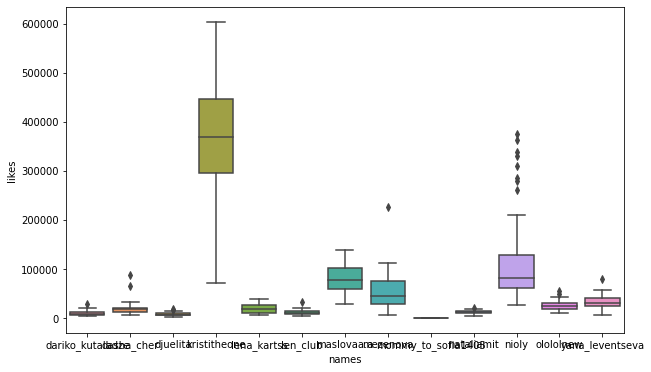

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='names', y='likes', data=df)
plt.show()

Понятно, что разброс по лайкам среди блогеров очень большой, поэтому возьмем 10% самых популярных постов каждого блогера:

In [41]:
df5 = df.groupby('names', group_keys=False)['likes'].nlargest(5).to_frame().reset_index()
df5['lem_text'] = df5['level_1'].apply(lambda x: df1['lemmatized_text'][x])
df5 = df5.groupby(['names'], as_index = False).agg({'lem_text': ''.join})
df5.to_excel('most_liked.xlsx', header=False, index=False)
df5.head(2)

,names,lem_text
0,dariko_kutaladze,Говорить как год встретить так он и. Поэтому я...
1,dasha_cher,Мы это сделать. Мы побить собственный рекорд в...


## Создание двух газетных корпусов: лематизированного и частеречного


In [42]:
from zipfile import ZipFile
file_name = 'news.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [43]:
news = []

In [44]:
import os

for filename in os.listdir('news'):
    news.append(read_txt(os.path.join('news', filename)))

In [45]:
news_lem = [lemmatize_text(elem) for elem in news]

In [46]:
with open ('news.txt', 'w') as f:
  f.write('\n\n'.join(news_lem))

In [47]:
news_pos = [pos_text(elem) for elem in news]

In [48]:
with open ('news_pos.txt', 'w') as f:
  f.write('\n\n'.join(news_pos))

## Самые частые слова разных частей речи


In [49]:
st = '\n'.join(df['lemmatized_text'])

In [52]:
df0 = pd.DataFrame({'words':[t.lower() for t in word_tokenize(''.join(st.split('.'))) if t.isalpha()]})

In [53]:
df0.shape

(101310, 1)

In [54]:
f_df = df0.pivot_table(index=['words'], aggfunc='size').reset_index()

In [55]:
f_df['pos'] = f_df['words'].apply(lambda x: pos(x))

In [56]:
f_df = f_df.rename(columns={0:'count'})

# frequent verbs

In [57]:
f_df[(f_df['pos']=='VERB')|(f_df['pos']=='INFN')].sort_values(by=['count'], ascending=False).head(30)

,words,count,pos
1194,быть,1193,INFN
10106,хотеть,369,INFN
2601,есть,298,INFN
3112,знать,283,INFN
2246,делать,219,INFN
8234,сделать,194,INFN
2537,думать,169,INFN
4198,любить,168,INFN
8886,стать,151,INFN
8359,сказать,148,INFN


# frequent nouns

In [58]:
f_df[(f_df['pos']=='NOUN')].sort_values(by=['count'], ascending=False).head(30)

,words,count,pos
1997,год,519,NOUN
4607,мочь,399,NOUN
2266,день,283,NOUN
10227,человек,257,NOUN
2676,жизнь,255,NOUN
1636,время,247,NOUN
7604,раз,222,NOUN
7866,ребёнок,207,NOUN
4429,месяц,176,NOUN
6848,пост,158,NOUN


# frequent adjectives

In [ ]:
f_df[(f_df['pos']=='ADJS')|(f_df['pos']=='ADJF')].sort_values(by=['count'], ascending=False).head(30)

,words,count,pos,TF
4545,мой,588,ADJF,False
8202,свой,531,ADJF,False
10509,этот,455,ADJF,False
1330,весь,445,ADJF,False
3837,который,430,ADJF,False
9346,тот,395,ADJF,False
9147,такой,374,ADJF,False
5494,один,302,ADJF,False
10103,хороший,273,ADJF,False
1083,большой,271,ADJF,False


## Разница новостей и постов

Данные были перенесены из результатов работы в Voyant Tools

In [59]:
df_vis = pd.DataFrame({'names':['dariko', 'dasha', 'djuelita', 'kristi',
       'kartss', 'club', 'maslova', 'mezenova',
       'sofia1405', 'natalia', 'nioly', 'ololol',
       'yana'],
       'numbers':[0.312, 0.313, 0.314, 0.314, 0.300, 0.271, 0.250, 0.328, 0.300, 0.300, 0.268, 0.272, 0.300],
       'numbers2' : [0.140, 0.140, 0.140, 0.140, 0.140, 0.140, 0.140, 0.140, 0.140, 0.140, 0.140, 0.140, 0.140]})

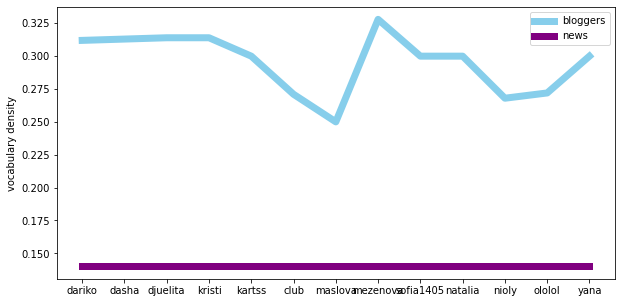

In [60]:
plt.figure(figsize=[10, 5])
sns.lineplot(data=df_vis, x="names", y="numbers", label='bloggers', color='skyblue', linewidth=7)
sns.lineplot(data=df_vis, x="names", y="numbers2", label = 'news', color='purple', linewidth=7)
plt.ylabel('vocabulary density')
plt.xlabel('')
plt.legend()
plt.show()